In [11]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure

In [12]:
file_path = "D:/ml/video_prediction/article/try2(30.04.2023)/train on 100 predict 160/"

im = Image.open( glob.glob(file_path + "train/batch4/*.png")[0] )

w, h = im.size
print(w, h)
print(os.getcwd())


1540 650
C:\Users\kurch\article\Using only images prediction


In [13]:
#initialize wandb and download dataset
hyperparams = {"num_epochs": 10, 
          "batch_size": 5,
          "height":h,
          "width":  w}
val_dir = file_path+'test'
train_dir =file_path+'train' 



In [4]:
wandb.init(config=hyperparams,project="Try9")
config = wandb.config


wandb: Currently logged in as: kurchenkoyurii. Use `wandb login --relogin` to force relogin


In [14]:
# generator to loop over train and test images
#load data in batches

def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cylinder_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.height, config.width, 3 * 5))
        output_images = np.zeros((batch_size, config.height, config.width, 3))
        random.shuffle(cylinder_dirs)
        if (counter+batch_size >= len(cylinder_dirs)):
            counter = 0 
        for i in range(batch_size):
            input_imgs = glob.glob(cylinder_dirs[counter + i] + "/cylinder_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cylinder_dirs[counter + i] + "/cylinder_result.png"))
            input_images[i] /= 255. #to normalize all data
            output_images[i] /= 255.
        yield (input_images, output_images) #return input images
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [6]:
#callback to log the images

class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(5, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

In [15]:
# Test the generator
gen = my_generator(5, train_dir)
videos, next_frame = next(gen)
print(videos[0].shape)
print(next_frame[0].shape)

(650, 1540, 15)
(650, 1540, 3)


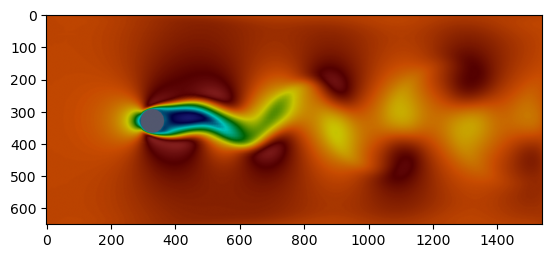

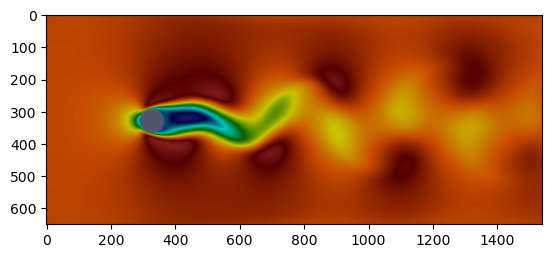

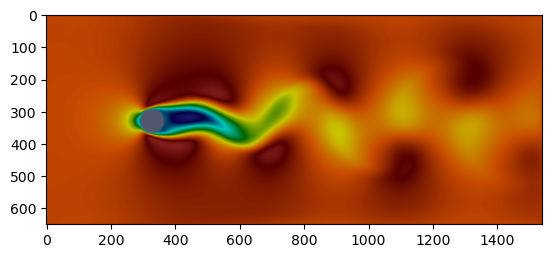

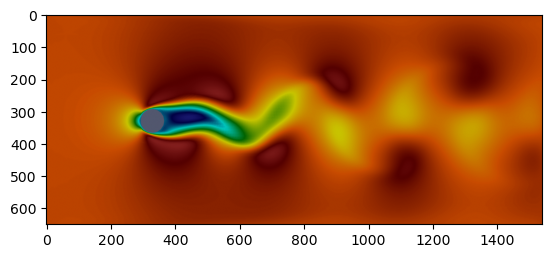

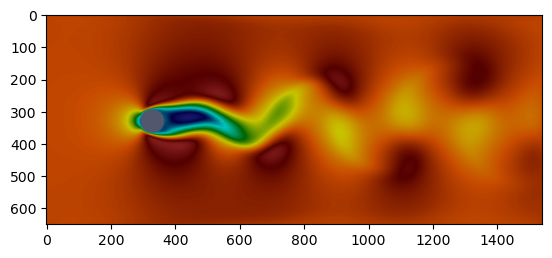

In [16]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

In [18]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))


In [33]:
#Sequential basic #1

wandb.init(config=hyperparams)
config = wandb.config

model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(config.height, config.width, 5 * 3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))



C:\Users\kurch\AppData\Local\Temp\ipykernel_26176\39578598.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(my_generator(config.batch_size, train_dir),


Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 0.1433 - perceptual_distance: 265.7239
Epoch 2/10
1/1 [==============================] - 17s 17s/step - loss: 0.1280 - perceptual_distance: 254.8015
Epoch 3/10
1/1 [==============================] - 17s 17s/step - loss: 0.1239 - perceptual_distance: 252.8469
Epoch 4/10
1/1 [==============================] - 15s 15s/step - loss: 0.1042 - perceptual_distance: 231.0221
Epoch 5/10
1/1 [==============================] - 14s 14s/step - loss: 0.0931 - perceptual_distance: 220.7106
Epoch 6/10
1/1 [==============================] - 16s 16s/step - loss: 0.0828 - perceptual_distance: 207.8730
Epoch 7/10
1/1 [==============================] - 16s 16s/step - loss: 0.0728 - perceptual_distance: 194.5583
Epoch 8/10
1/1 [==============================] - 15s 15s/step - loss: 0.0607 - perceptual_distance: 177.1837
Epoch 9/10
1/1 [==============================] - 15s 15s/step - loss: 0.0493 - perceptual_distance: 157.2825
Epoch 10/1

In [19]:
# Baseline model - just return the last layer #2

from keras.layers import Lambda, Reshape, Permute

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

model=Sequential()
model.add(Reshape((config.height, config.width,5,3), input_shape=(config.height, config.width, 5 * 3)))
model.add(Permute((1,2,4,3)))
model.add(Lambda(slice, input_shape=(config.height, config.width,3,5), output_shape=(config.height, config.width,3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))




epoch,▁█
loss,█▁
perceptual_distance,█▁
val_loss,█▁
val_perceptual_distance,█▁
best_epoch,1
best_val_loss,4e-05
epoch,1
loss,2e-05
perceptual_distance,1.23867
val_loss,4e-05


C:\Users\kurch\AppData\Local\Temp\ipykernel_288\3926441308.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(my_generator(config.batch_size, train_dir),


Epoch 1/10
1/1 [==============================] - 1s 623ms/steposs: 2.0116e-05 - perceptual_distance: 1.35


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best)... Done. 0.0s


20/20 [==============================] - 120s 6s/step - loss: 2.0116e-05 - perceptual_distance: 1.3557 - val_loss: 4.7959e-05 - val_perceptual_distance: 2.2082
Epoch 2/10
1/1 [==============================] - 0s 491ms/steposs: 2.4782e-05 - perceptual_distance: 1.60


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best)... Done. 0.0s


20/20 [==============================] - 116s 6s/step - loss: 2.4782e-05 - perceptual_distance: 1.6041 - val_loss: 4.2815e-05 - val_perceptual_distance: 2.3518
Epoch 3/10
1/1 [==============================] - 1s 535ms/steposs: 2.5781e-05 - perceptual_distance: 1.52


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230730_170816-w6vcwxw6\files\model-best)... Done. 0.0s


20/20 [==============================] - 119s 6s/step - loss: 2.5781e-05 - perceptual_distance: 1.5211 - val_loss: 3.9385e-05 - val_perceptual_distance: 2.1321
Epoch 4/10
20/20 [==============================] - 108s 6s/step - loss: 2.7018e-05 - perceptual_distance: 1.5213 - val_loss: 5.1540e-05 - val_perceptual_distance: 2.3077
Epoch 5/10
20/20 [==============================] - 108s 6s/step - loss: 2.6526e-05 - perceptual_distance: 1.5248 - val_loss: 4.1883e-05 - val_perceptual_distance: 2.2632
Epoch 6/10
20/20 [==============================] - 88s 5s/step - loss: 2.1021e-05 - perceptual_distance: 1.3804 - val_loss: 4.0044e-05 - val_perceptual_distance: 2.1893
Epoch 7/10
20/20 [==============================] - 83s 4s/step - loss: 2.3861e-05 - perceptual_distance: 1.5023 - val_loss: 4.2809e-05 - val_perceptual_distance: 2.2245
Epoch 8/10
20/20 [==============================] - 83s 4s/step - loss: 2.5565e-05 - perceptual_distance: 1.3846 - val_loss: 4.4839e-05 - val_perceptual_dista

In [47]:
# Conv3D #3

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((config.height, config.width,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(config.height, config.width,3,5), output_shape=(config.height, config.width,3))(permuted)
conv_output = Conv3D(1, (3,3,3), padding="same")(permuted)
conv_output_reshape = Reshape((config.height, config.width,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

C:\Users\kurch\AppData\Local\Temp\ipykernel_26176\1849951745.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(my_generator(config.batch_size, train_dir),


Epoch 1/10
1/1 [==============================] - 3s 3s/step- loss: 0.3749 - perceptual_distance: 492.889


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 251s 16s/step - loss: 0.3749 - perceptual_distance: 492.8891 - val_loss: 0.1552 - val_perceptual_distance: 326.4032
Epoch 2/10
1/1 [==============================] - 2s 2s/step- loss: 0.0862 - perceptual_distance: 230.29


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 175s 11s/step - loss: 0.0862 - perceptual_distance: 230.2951 - val_loss: 0.0375 - val_perceptual_distance: 147.1601
Epoch 3/10
1/1 [==============================] - 3s 3s/step- loss: 0.0178 - perceptual_distance: 95.24


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.1s


16/16 [==============================] - 206s 13s/step - loss: 0.0178 - perceptual_distance: 95.2432 - val_loss: 0.0066 - val_perceptual_distance: 52.4620
Epoch 4/10
1/1 [==============================] - 3s 3s/step- loss: 0.0060 - perceptual_distance: 39.683


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.1s


16/16 [==============================] - 197s 12s/step - loss: 0.0060 - perceptual_distance: 39.6835 - val_loss: 0.0050 - val_perceptual_distance: 32.5129
Epoch 5/10
1/1 [==============================] - 3s 3s/step- loss: 0.0040 - perceptual_distance: 33.12


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 150s 9s/step - loss: 0.0040 - perceptual_distance: 33.1231 - val_loss: 0.0031 - val_perceptual_distance: 31.5042
Epoch 6/10
1/1 [==============================] - 3s 3s/step- loss: 0.0024 - perceptual_distance: 27.52


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 149s 9s/step - loss: 0.0024 - perceptual_distance: 27.5272 - val_loss: 0.0019 - val_perceptual_distance: 24.8043
Epoch 7/10
1/1 [==============================] - 3s 3s/step- loss: 0.0016 - perceptual_distance: 22.78


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 148s 9s/step - loss: 0.0016 - perceptual_distance: 22.7879 - val_loss: 0.0012 - val_perceptual_distance: 20.0525
Epoch 8/10
1/1 [==============================] - 2s 2s/step- loss: 0.0011 - perceptual_distance: 19.243


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.0s


16/16 [==============================] - 229s 15s/step - loss: 0.0011 - perceptual_distance: 19.2434 - val_loss: 7.9716e-04 - val_perceptual_distance: 16.6280
Epoch 9/10
1/1 [==============================] - 5s 5s/step- loss: 7.3557e-04 - perceptual_distance: 15.672


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.1s


16/16 [==============================] - 243s 16s/step - loss: 7.3557e-04 - perceptual_distance: 15.6725 - val_loss: 5.9948e-04 - val_perceptual_distance: 14.1219
Epoch 10/10
1/1 [==============================] - 6s 6s/step- loss: 5.5752e-04 - perceptual_distance: 13.560


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_133541-0f77hwhl\files\model-best)... Done. 0.1s


16/16 [==============================] - 335s 21s/step - loss: 5.5752e-04 - perceptual_distance: 13.5602 - val_loss: 4.9675e-04 - val_perceptual_distance: 12.7973


In [48]:
# Conv2DLSTM with Gaussian Noise #4
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((config.height,config.width,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(config.height,config.width,3,5), output_shape=(config.height,config.width,3))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(6, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(3, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▁▁▁▁▁▁▁▁
perceptual_distance,█▄▂▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁
val_perceptual_distance,█▄▂▁▁▁▁▁▁▁
best_epoch,9
best_val_loss,0.0005
epoch,9
loss,0.00056
perceptual_distance,13.56017
val_loss,0.0005


C:\Users\kurch\AppData\Local\Temp\ipykernel_26176\2833176643.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(my_generator(config.batch_size, train_dir),


Epoch 1/10
1/1 [==============================] - 19s 19s/steploss: 0.0202 - perceptual_distance: 100.115


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.0s


16/16 [==============================] - 916s 57s/step - loss: 0.0202 - perceptual_distance: 100.1152 - val_loss: 0.0029 - val_perceptual_distance: 42.6060
Epoch 2/10
1/1 [==============================] - 18s 18s/steploss: 0.0115 - perceptual_distance: 75.697


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.0s


16/16 [==============================] - 863s 55s/step - loss: 0.0115 - perceptual_distance: 75.6976 - val_loss: 6.3752e-04 - val_perceptual_distance: 19.6806
Epoch 3/10
1/1 [==============================] - 20s 20s/steploss: 0.0107 - perceptual_distance: 73.040


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.1s


16/16 [==============================] - 896s 55s/step - loss: 0.0107 - perceptual_distance: 73.0407 - val_loss: 2.0498e-04 - val_perceptual_distance: 8.5498
Epoch 4/10
1/1 [==============================] - 20s 20s/steploss: 0.0104 - perceptual_distance: 71.913


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.0s


16/16 [==============================] - 876s 55s/step - loss: 0.0104 - perceptual_distance: 71.9132 - val_loss: 1.2861e-04 - val_perceptual_distance: 5.9469
Epoch 5/10
16/16 [==============================] - 879s 55s/step - loss: 0.0102 - perceptual_distance: 71.1722 - val_loss: 1.3593e-04 - val_perceptual_distance: 4.6870
Epoch 6/10
1/1 [==============================] - 20s 20s/steploss: 0.0099 - perceptual_distance: 70.501


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.1s


16/16 [==============================] - 881s 56s/step - loss: 0.0099 - perceptual_distance: 70.5014 - val_loss: 1.0697e-04 - val_perceptual_distance: 4.3946
Epoch 7/10
16/16 [==============================] - 867s 55s/step - loss: 0.0098 - perceptual_distance: 69.8910 - val_loss: 1.1499e-04 - val_perceptual_distance: 4.4555
Epoch 8/10
16/16 [==============================] - 862s 54s/step - loss: 0.0096 - perceptual_distance: 69.2690 - val_loss: 1.1349e-04 - val_perceptual_distance: 4.4963
Epoch 9/10
1/1 [==============================] - 18s 18s/steploss: 0.0094 - perceptual_distance: 68.665


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\kurch\article\Using only images prediction\wandb\run-20230501_144445-z8ce0w11\files\model-best)... Done. 0.0s


16/16 [==============================] - 858s 54s/step - loss: 0.0094 - perceptual_distance: 68.6656 - val_loss: 1.0689e-04 - val_perceptual_distance: 4.2902
Epoch 10/10
16/16 [==============================] - 841s 53s/step - loss: 0.0092 - perceptual_distance: 68.0230 - val_loss: 1.1587e-04 - val_perceptual_distance: 4.5465


In [ ]:

from keras.layers import Lambda, Reshape, Permute, Input
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((config.height,config.width,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(config.height,config.width,3,5), output_shape=(config.height,config.width,3))(permuted)
model=Model(inputs=[inp], outputs=[last_layer])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

In [ ]:
# Conv2DLSTM with Gaussian Noise
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((config.height,config.width,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(config.height,config.width,3,5), output_shape=(config.height,config.width,3))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

In [ ]:
def relu(x):
    return max(0.0, x)